In [1]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
landmarks = pd.read_csv(main_path+"/Papilionidae_landmarks.txt", sep="\t", header=None)
aligned = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

In [3]:
print(aligned.shape)
print(landmarks.shape)

print(aligned.iloc[:, 0])
print(landmarks.iloc[:, 0])

(4480, 102)
(4480, 102)
0                      1039027751_0_default
1                      1039027751_0_default
2                      1039028343_0_default
3                      1039028343_0_default
4                      1039033323_0_default
                       ...                 
4475    932851590_2011_07_19_IMG_091426.JPG
4476                    932851670_0_default
4477                    932851670_0_default
4478                    932851678_0_default
4479                    932851678_0_default
Name: 0, Length: 4480, dtype: object
0                      1039027751_0_default
1                      1039027751_0_default
2                      1039028343_0_default
3                      1039028343_0_default
4                      1039033323_0_default
                       ...                 
4475    932851590_2011_07_19_IMG_091426.JPG
4476                    932851670_0_default
4477                    932851670_0_default
4478                    932851678_0_default
4479           

In [4]:
def convert_to_slice(df_subgroup):
    x_coords = df_subgroup[df_subgroup.iloc[:, 1] == "x-coordinates"].iloc[:, 2:].values
    y_coords = -df_subgroup[df_subgroup.iloc[:, 1] == "y-coordinates"].iloc[:, 2:].values
    return jnp.column_stack((x_coords.ravel(), y_coords.ravel()))

# Split dataframe by "Name" and convert each subgroup back to a 2D slice
def stack_slices(df_group):
    groups = [group for _, group in df_group.groupby(df_group.iloc[:, 0])]
    list_of_2d_slices = [convert_to_slice(group) for group in groups]
    return jnp.dstack(list_of_2d_slices)

In [5]:
def plot_wings(marks, sp=plt):
    s = 50
    for n in [0,s]:
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        sp.plot(xs, ys)
    sp.axis("equal")

In [6]:
dataAl = stack_slices(aligned)
data = stack_slices(landmarks)

In [7]:
print(data.shape)

(100, 2, 2240)


In [8]:
(h,t,N) = data.shape
assert h == 100 and t == 2
data_flat = np.empty((200,N))
for i in range(N):
    data_flat[:,i] = data[:,:,i].ravel()


In [9]:
from math import sin, cos, atan

# rotates 2d landmarks theta radians around origin
def rotate(marks,th):
    R = np.array([[cos(th), -sin(th)], [sin(th), cos(th)]])
    return jnp.dot(marks, R)

# removes translational and rotational components from 2D landmarks
def proscutes_normalize(marks):
    # translate data so origin is mean

    (n,d) = marks.shape
    assert d == 2, "invalid marks shape"

    mean = np.mean(marks, axis=0)
    t = marks - mean

    # mean of each wing
    (a1,b1) = np.mean(t[50:],axis=0)
    (a2,b2) = np.mean(t[:50],axis=0)

    # average angle from wing mean to origin
    th1 = atan(b1/a1)
    th2 = atan(b2/a2)
    th = (th1 + th2) / 2

    # rotate data so wings are horizontally aligned
    # (that is, angle from wing mean to origin is approx. zero)
    return rotate(t, th)


def proscutes_flat(flat_marks):
    assert len(flat_marks.shape) == 1, "input not flat"
    marks = np.reshape(flat_marks, (-1,2))
    pn_marks = proscutes_normalize(marks)
    return pn_marks # .ravel()

In [10]:
(h,t,N) = data.shape
assert h == 100 and t == 2
print(data.shape)
data_normalized = np.apply_along_axis(proscutes_flat, 0, data_flat)
print(data_normalized.shape)

(100, 2, 2240)
(100, 2, 2240)


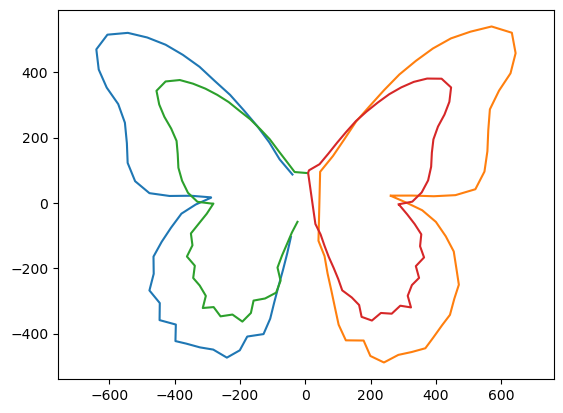

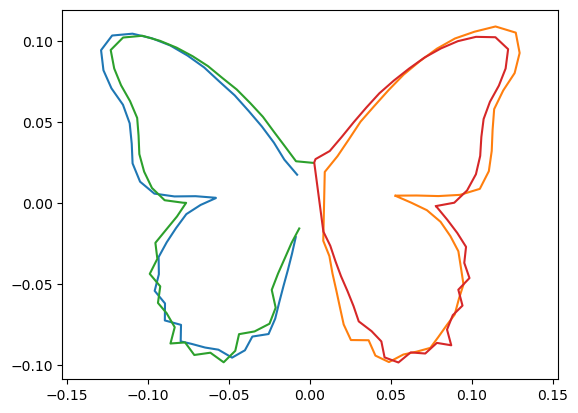

In [11]:
plot_wings(data_normalized[:,:,0])
plot_wings(data_normalized[:,:,5])
plt.show()
plot_wings(dataAl[:,:,0])
plot_wings(dataAl[:,:,5])

In [12]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
print(selu(x))

[0.        1.05      2.1       3.1499999 4.2      ]


In [13]:
ser = (metadata.iloc[:,2]).astype("category")
ser = ser.cat.reorder_categories(
    ser[~ser.duplicated()].tolist(),  # Get categories by first appearance
    ordered=True  # Makes it an ordered Categorical
)
#print(ser)

In [14]:
species = []
species_data = []

# Iterate over each unique species
for spc in ser.cat.categories:
    print(spc)
    species.append(spc)
    # Get the indices corresponding to the current species
    indices = ser[ser == spc].index.tolist()
    # Extract the corresponding slices from axis 2 of `data`
    #spc_data = data_normalized[:, :, indices]
    spc_data = dataAl[:, :, indices]
    # Append the numpy array to the result list
    species_data.append(spc_data)


Battus_polydamas
Papilio_aristodemus
Parides_photinus
Papilio_thoas
Papilio_polytes
Teinopalpus_imperialis
Graphium_agamemnon
Papilio_glaucus
Papilio_cresphontes
Papilio_deiphobus
Parides_agavus
Papilio_polyxenes
Papilio_protenor
Parides_eurimedes
Papilio_troilus
Papilio_zelicaon
Papilio_xuthus
Papilio_ambrax
Cressida_cressida
Pachliopta_kotzebuea
Baronia_brevicornis
Parnassius_orleans
Sericinus_montela
Battus_belus
Protographium_marcellus
Luehdorfia_puziloi
Byasa_alcinous
Trogonoptera_brookiana
Ornithoptera_richmondia
Troides_rhadamantus
Papilio_gigon
Pharmacophagus_antenor
Graphium_sarpedon
Zerynthia_polyxena
Atrophaneura_dixoni
Pachliopta_aristolochiae
Graphium_evemon
Losaria_coon
Allancastria_cerisyi
Euryades_corethrus
Iphiclides_podalirius
Meandrusa_sciron
Parnassius_honrathi
Atrophaneura_semperi
Papilio_slateri
Archon_apollinus
Papilio_phestus
Hypermnestra_helios


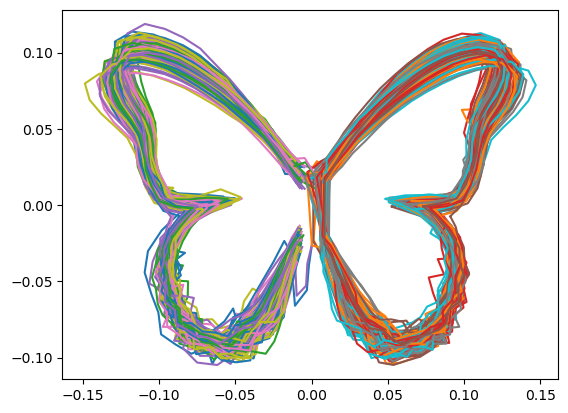

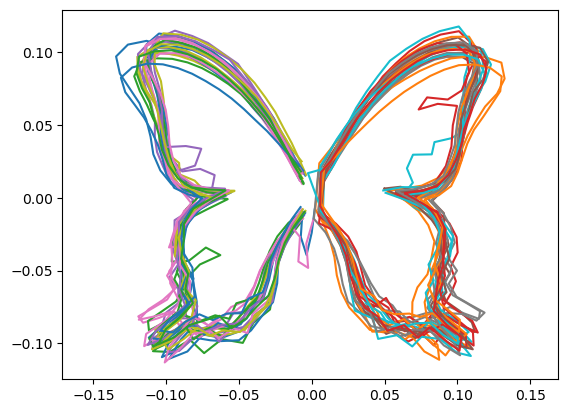

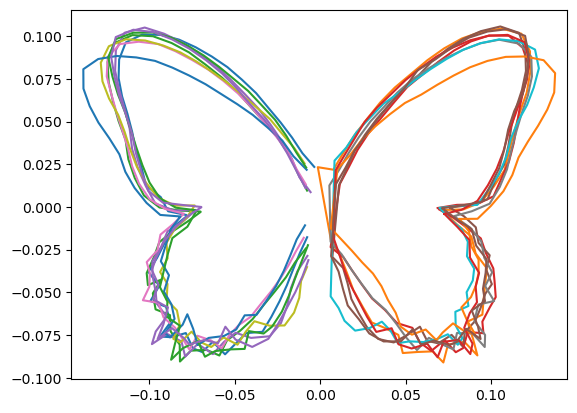

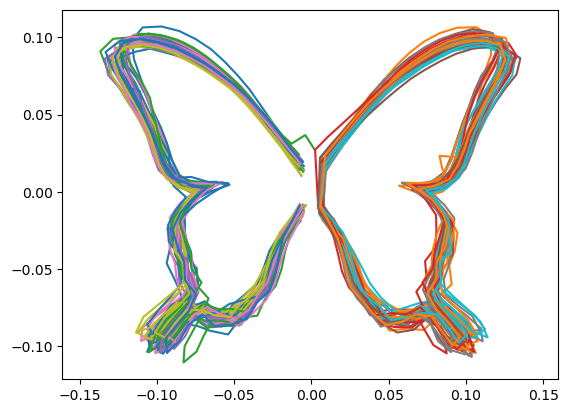

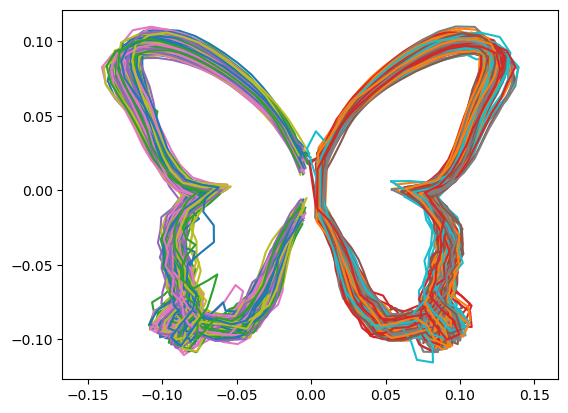

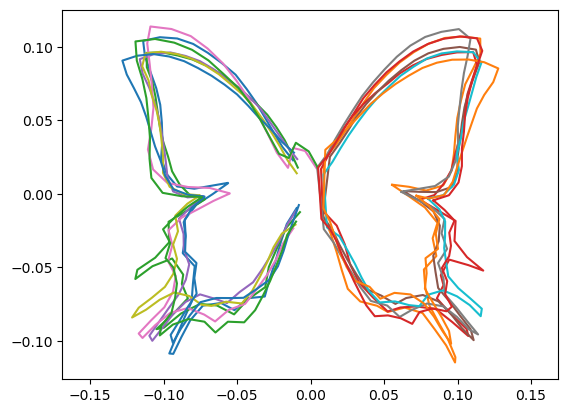

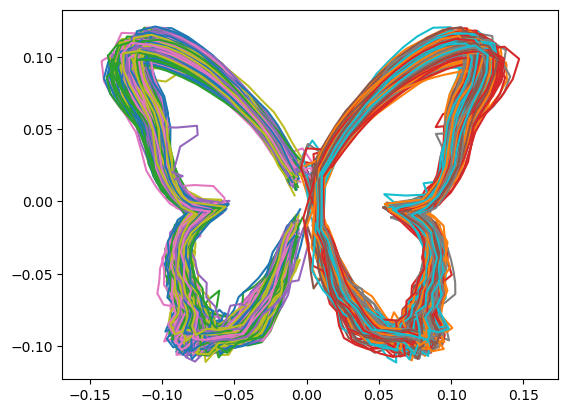

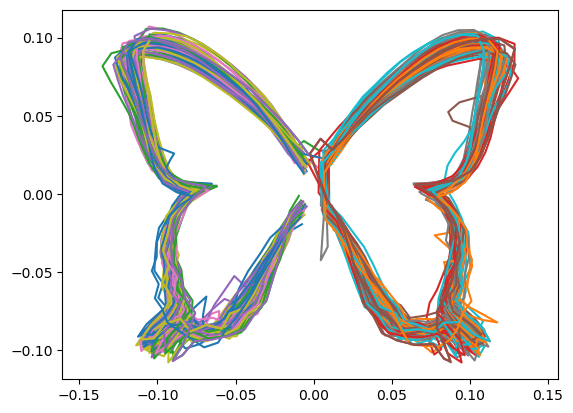

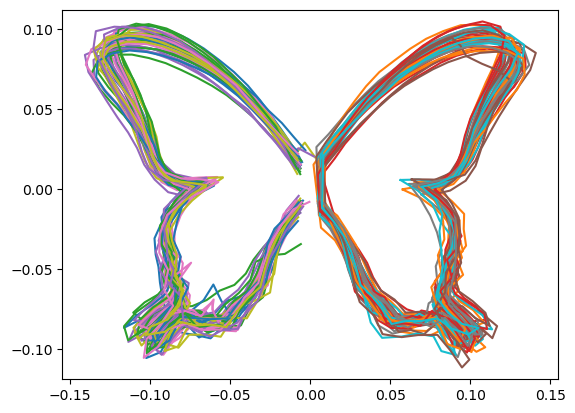

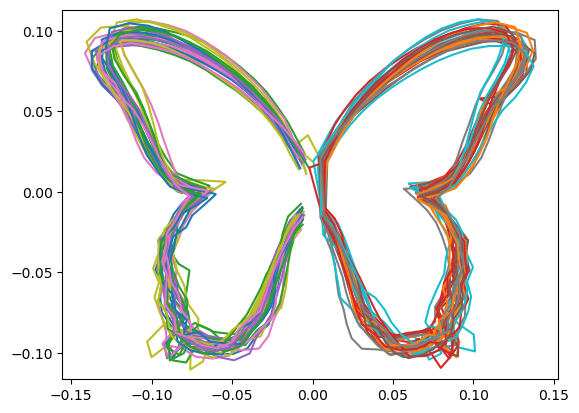

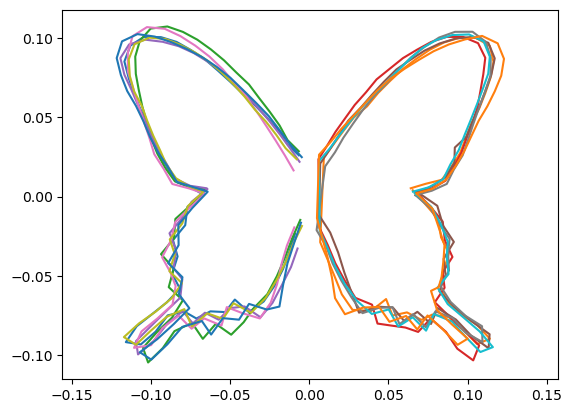

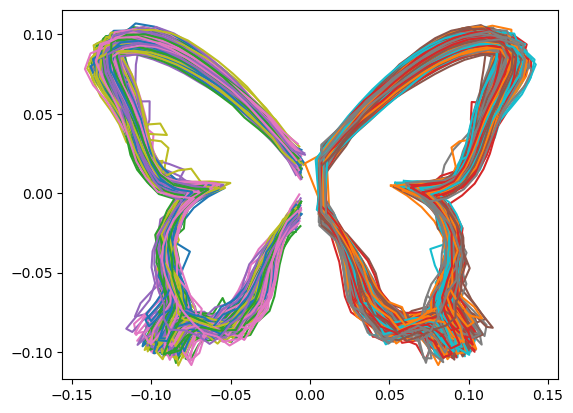

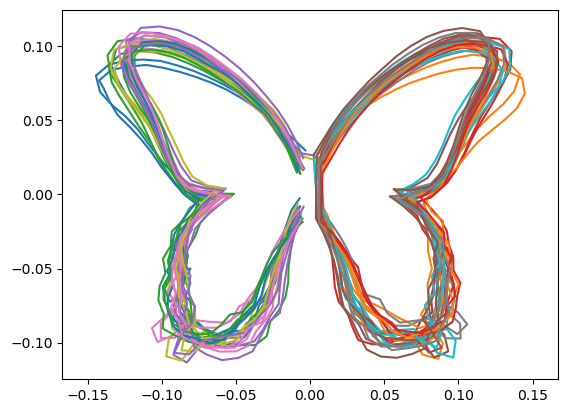

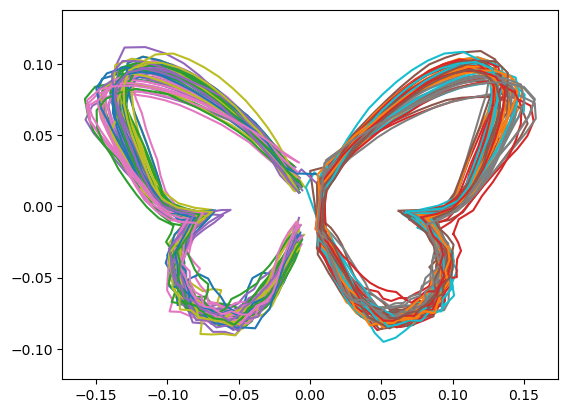

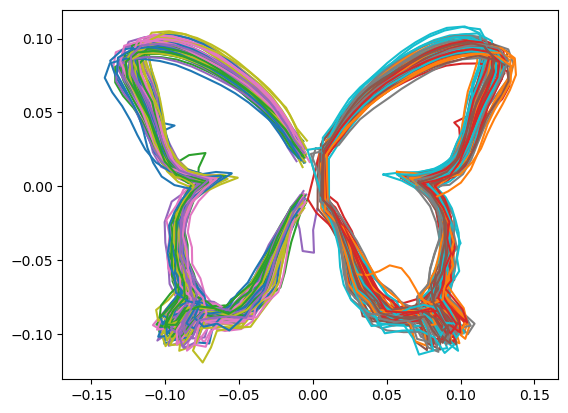

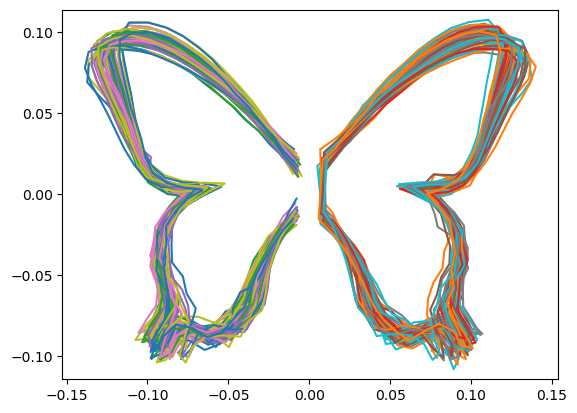

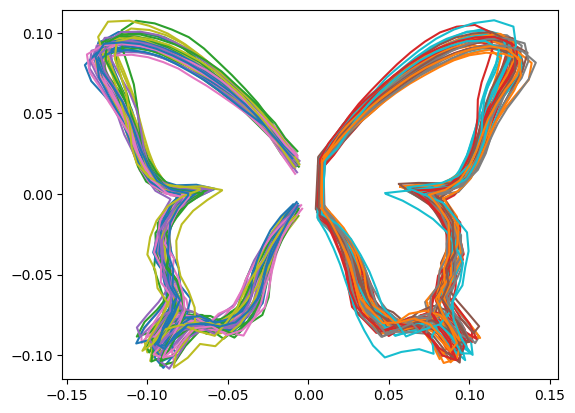

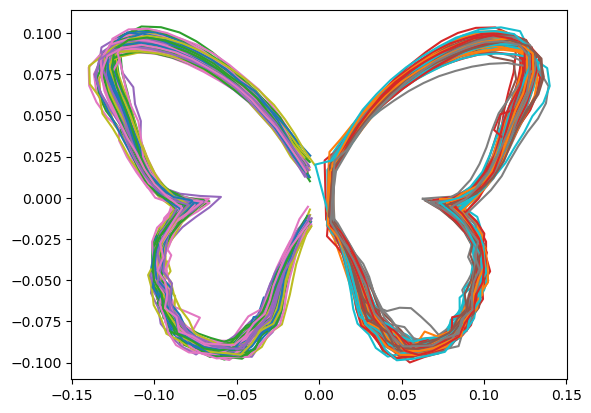

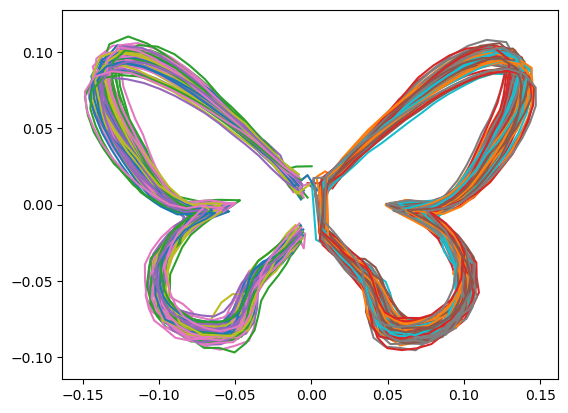

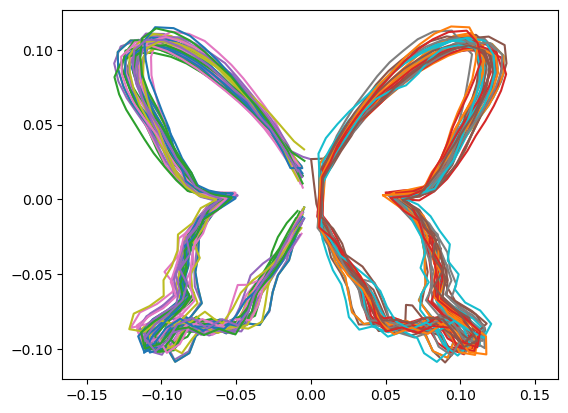

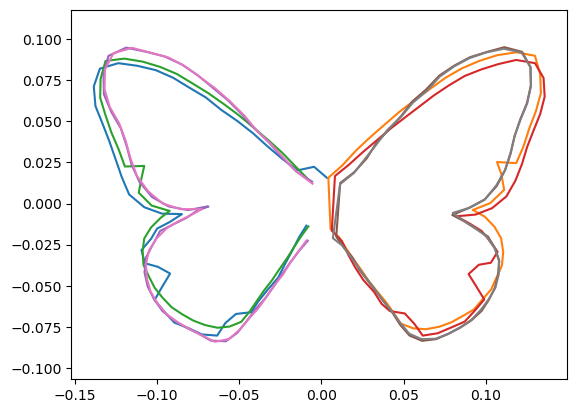

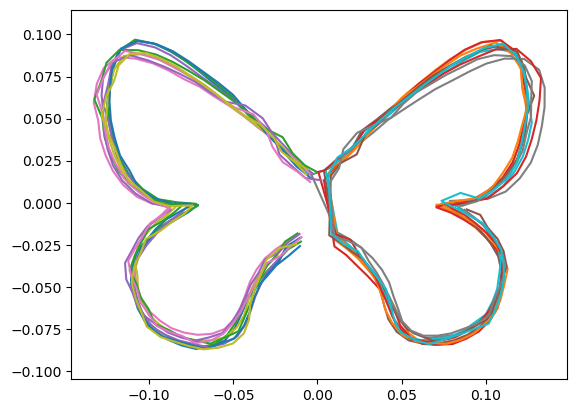

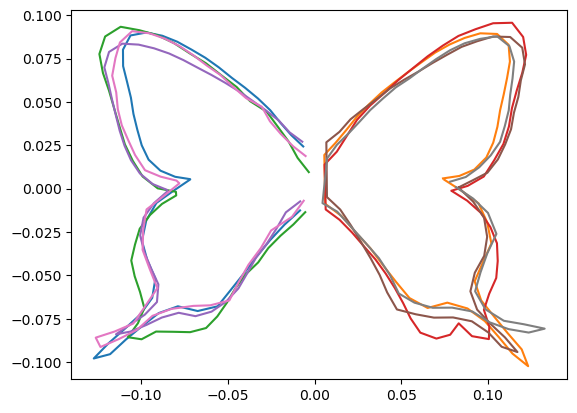

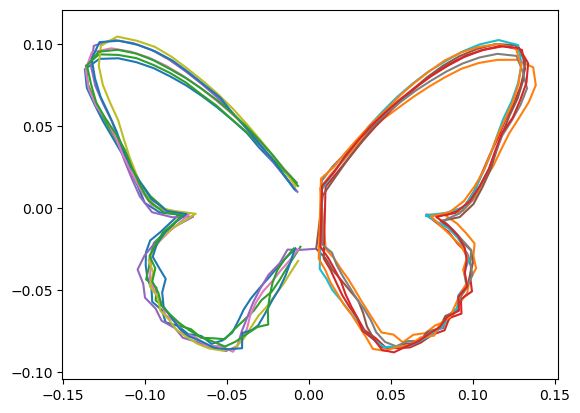

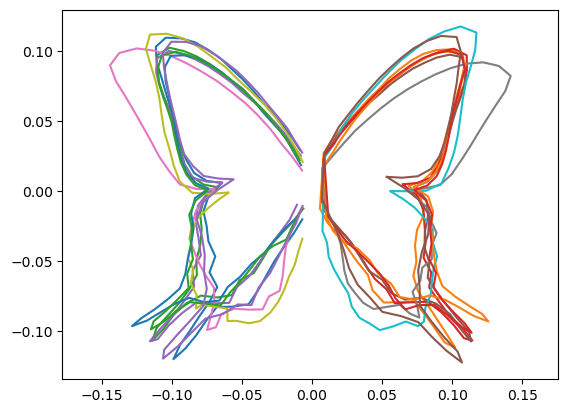

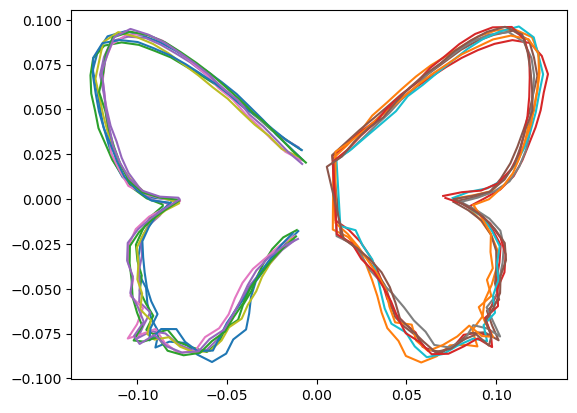

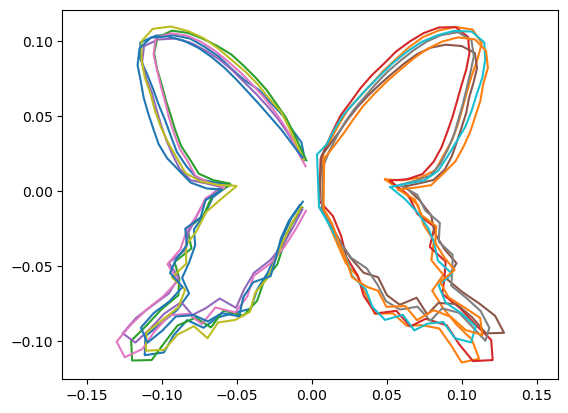

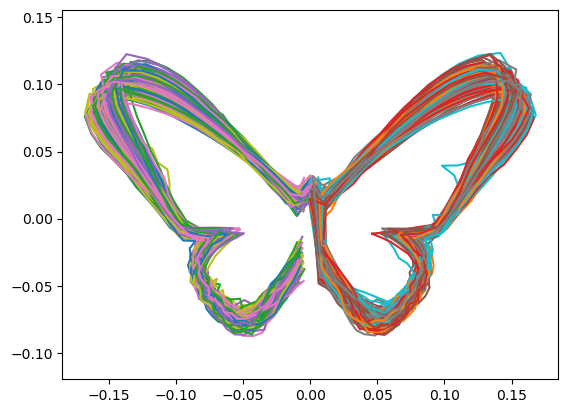

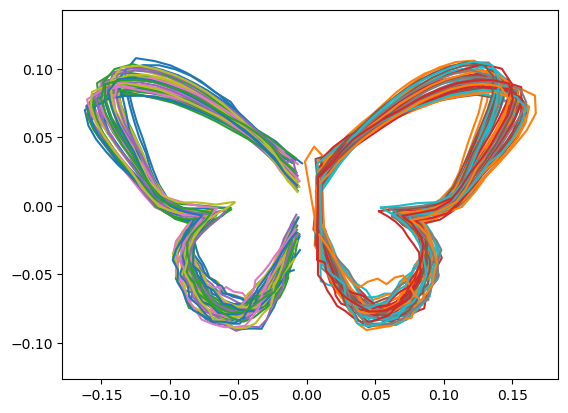

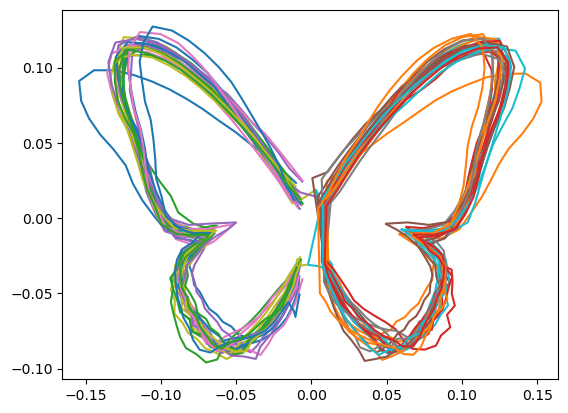

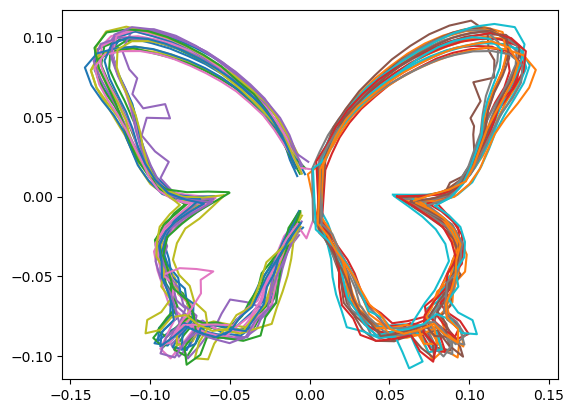

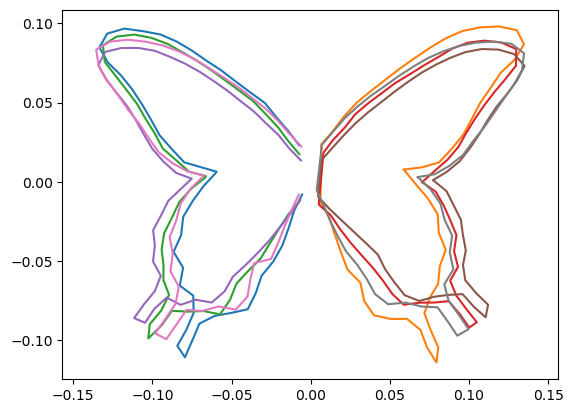

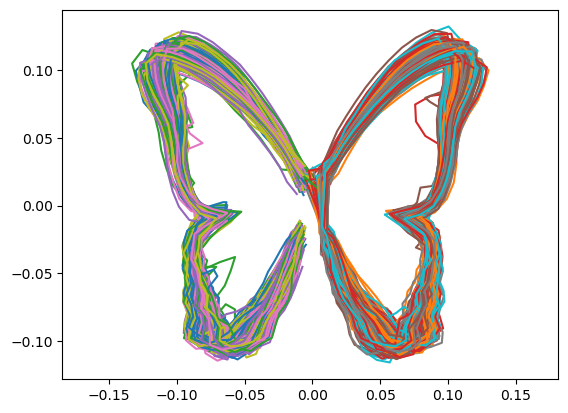

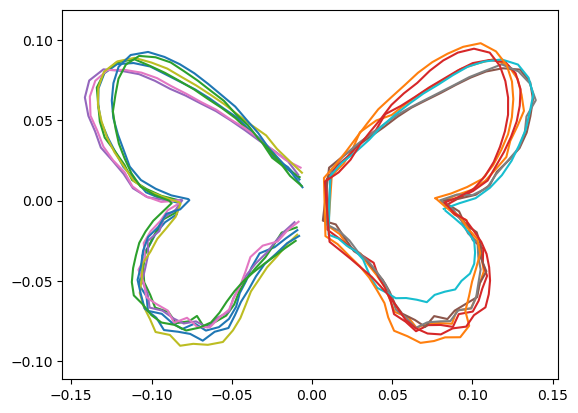

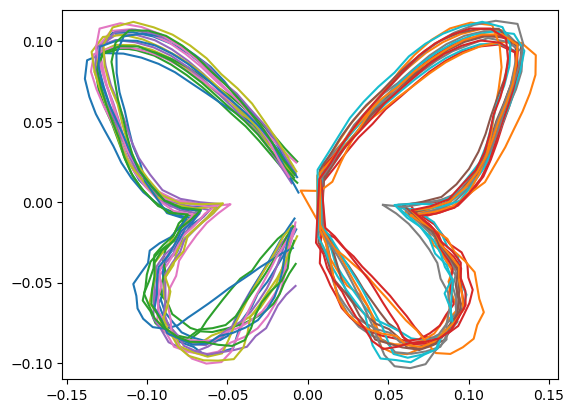

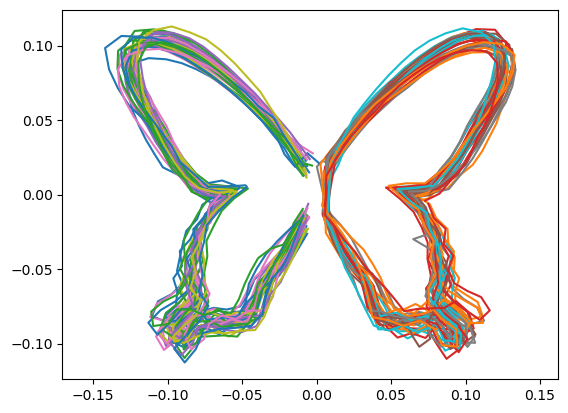

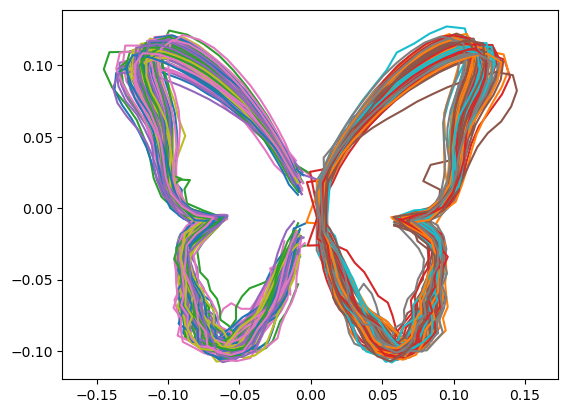

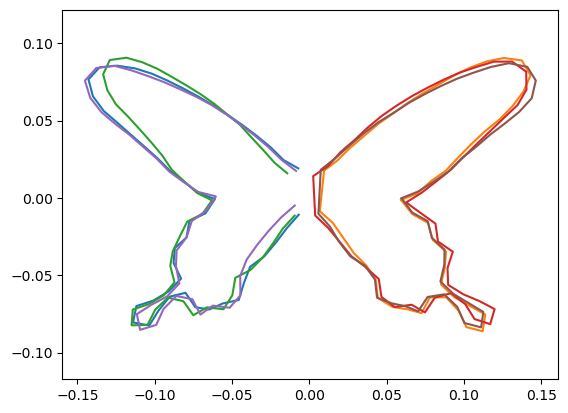

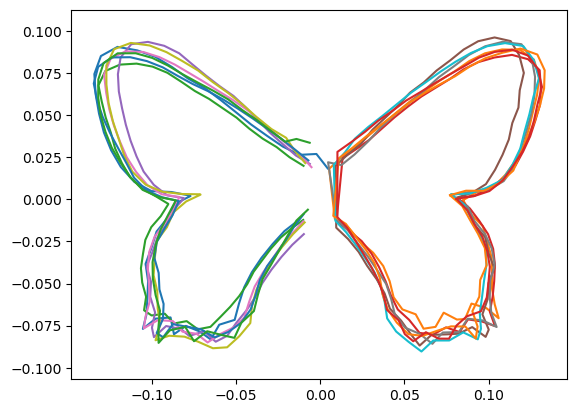

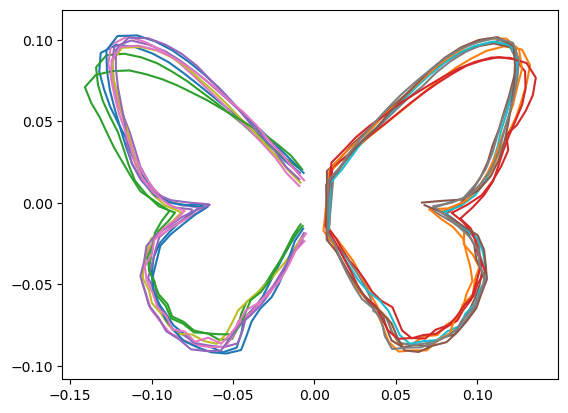

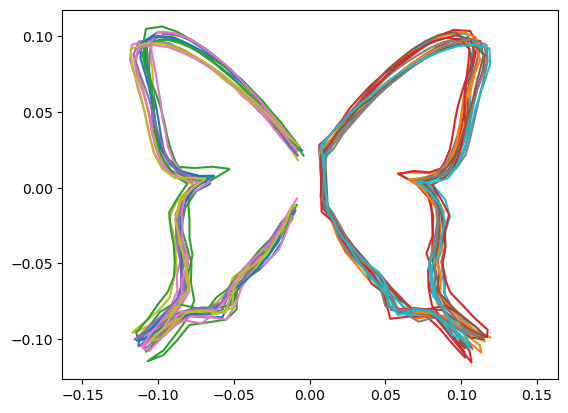

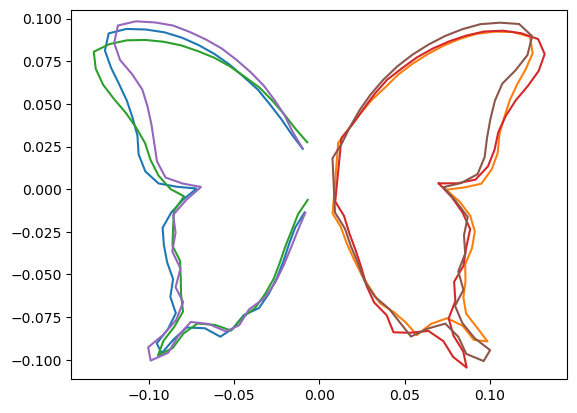

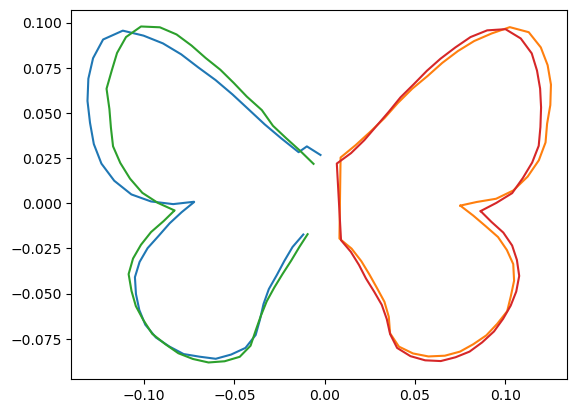

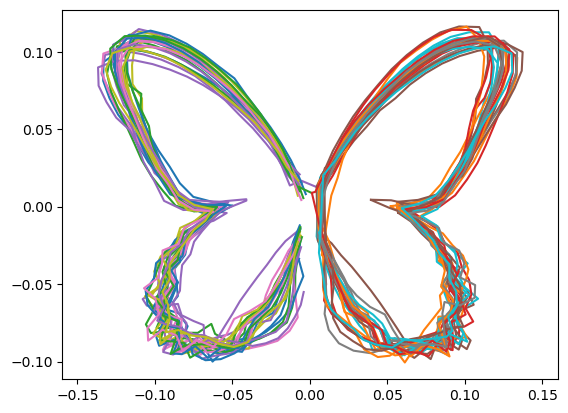

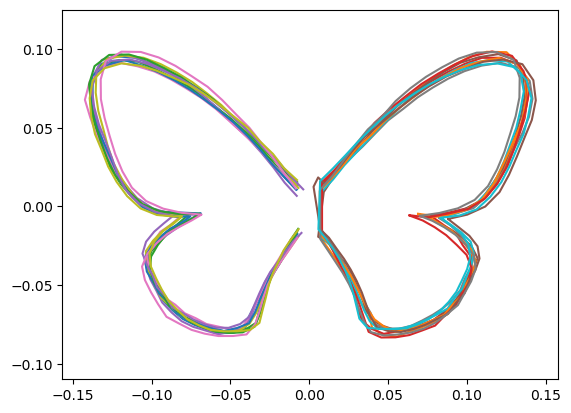

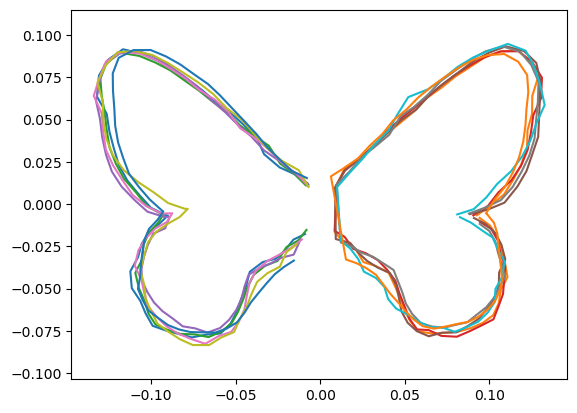

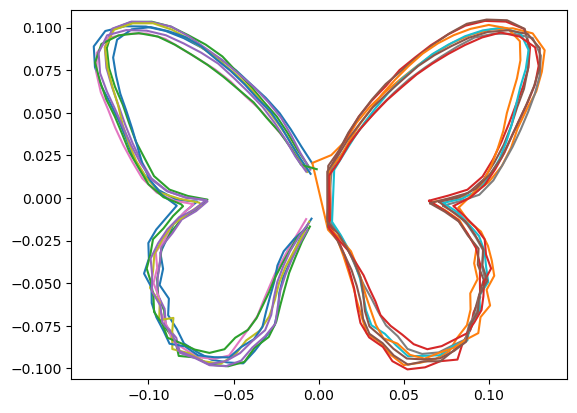

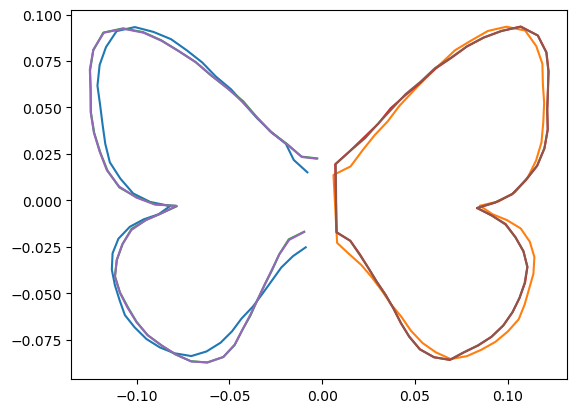

In [15]:
N = len(species)

for i in range(N):
    s = species_data[i]
    (h,t,n) = s.shape
    assert h == 100 and t == 2, "invalid dimensions"

    for j in range(n):
        plot_wings(s[:,:,j])
    plt.show()
    #print(f'{species[i]:_<30}{n}')

In [16]:
print(species_data[3].shape)

(100, 2, 36)


In [17]:


for i in range(N):
    s = species_data[i]
    (_,_,n) = s.shape
    st = translated[i]

    #ms = np.empty((2,n))
    for j in range(n):
        ss = s[:,:,j]
        mean = np.mean(ss, axis=0)
        st[:,:,j] = ss - mean

    #sp_mean = np.mean(ms, axis=1)
    print(st)


NameError: name 'translated' is not defined

In [19]:
from scipy.spatial import procrustes

a = np.array([[1, 3], [1, 2], [1, 1], [2, 1]], 'd')
b = np.array([[4, -2], [4, -4], [4, -6], [2, -6]], 'd')
mtx1, mtx2, disparity = procrustes(a, b)
round(disparity)

0

In [29]:
a = species_data[0][:,:,0]
b = species_data[0][:,:,1]
mtx1, mtx2, disparity = procrustes(a, b)

In [31]:
print (mtx1)

[[-0.00740472 -0.01761073]
 [-0.01499797 -0.02712733]
 [-0.02106856 -0.03772582]
 [-0.02818097 -0.04790359]
 [-0.03607474 -0.05776078]
 [-0.04426904 -0.06749777]
 [-0.05348512 -0.07633319]
 [-0.06254093 -0.08524875]
 [-0.07253836 -0.09284199]
 [-0.08295654 -0.09935336]
 [-0.09409598 -0.10410164]
 [-0.10591661 -0.10726716]
 [-0.11845849 -0.10650583]
 [-0.1255108  -0.09769045]
 [-0.12438884 -0.08528882]
 [-0.11980083 -0.07406924]
 [-0.11302902 -0.06377127]
 [-0.10924241 -0.0522111 ]
 [-0.10838091 -0.03964918]
 [-0.10824066 -0.02754807]
 [-0.10397322 -0.01618825]
 [-0.09539826 -0.00861503]
 [-0.08311683 -0.00655143]
 [-0.07009411 -0.00633105]
 [-0.05769246 -0.0049887 ]
 [-0.05769246 -0.00478835]
 [-0.06718904 -0.00088154]
 [-0.07612463  0.00448783]
 [-0.08273616  0.01290251]
 [-0.08872662  0.02141737]
 [-0.09399581  0.03035297]
 [-0.09415609  0.04091138]
 [-0.09706116  0.05102903]
 [-0.09093046  0.05894284]
 [-0.09135119  0.06940109]
 [-0.08145392  0.0723863 ]
 [-0.08197484  0.082524  ]
 

In [16]:

def get_translation(shape):
  '''
  Calculates a translation for x and y
  axis that centers shape around the
  origin
  Args:
    shape(2n x 1 NumPy array) an array
    containing x coordinates of shape
    points as first column and y coords
    as second column
   Returns:
    translation([x,y]) a NumPy array with
    x and y translation coordinates
  '''

  mean_x = np.mean(shape[::2]).astype(np.int)
  mean_y = np.mean(shape[1::2]).astype(np.int)

  return np.array([mean_x, mean_y])

def translate(shape):
  '''
  Translates shape to the origin
  Args:
    shape(2n x 1 NumPy array) an array
    containing x-coordinates of shape
    points as first column and y-coords
    as second column
  '''
  mean_x, mean_y = get_translation(shape)
  shape[::2] -= mean_x
  shape[1::2] -= mean_y

In [17]:
from scipy.linalg import norm
from math import atan
def get_rotation_scale(reference_shape, shape):
    '''
    Calculates rotation and scale
    that would optimally align shape
    with reference shape
    Args:
        reference_shape(2nx1 NumPy array), a shape that
        serves as reference for scaling and
        alignment

        shape(2nx1 NumPy array), a shape that is scaled
        and aligned

    Returns:
        scale(float), a scaling factor
        theta(float), a rotation angle in radians
    '''

    a = np.dot(shape, reference_shape) / norm(reference_shape)**2

    #separate x and y for the sake of convenience
    ref_x = reference_shape[::2]
    ref_y = reference_shape[1::2]

    x = shape[::2]
    y = shape[1::2]

    b = np.sum(x*ref_y - ref_x*y) / norm(reference_shape)**2

    scale = np.sqrt(a**2+b**2)
    theta = atan(b / max(a, 10**-10)) #avoid dividing by 0

    return round(scale,1), round(theta,2)

In [18]:
from math import sin, cos

def get_rotation_matrix(theta):

    return np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

def scale(shape, scale):

    return shape / scale

def rotate(shape, theta):
    '''
    Rotates a shape by angle theta
    Assumes a shape is centered around
    origin
    Args:
        shape(2nx1 NumPy array) an shape to be rotated
        theta(float) angle in radians
    Returns:
        rotated_shape(2nx1 NumPy array) a rotated shape
    '''

    matr = get_rotation_matrix(theta)

    #reshape so that dot product is eascily computed
    temp_shape = shape.reshape((-1,2)).T

    #rotate
    rotated_shape = np.dot(matr, temp_shape)

    return rotated_shape.T.reshape(-1)

In [ ]:
def procrustes_analysis(reference_shape, shape):
    '''
    Scales, and rotates a shape optimally to
    be aligned with a reference shape
    Args:
        reference_shape(2nx1 NumPy array), a shape that
        serves as reference alignment

        shape(2nx1 NumPy array), a shape that is aligned

    Returns:
        aligned_shape(2nx1 NumPy array), an aligned shape
        translated to the location of reference shape
    '''
    #copy both shapes in caseoriginals are needed later
    temp_ref = np.copy(reference_shape)
    temp_sh = np.copy(shape)

    translate(temp_ref)
    translate(temp_sh)

    #get scale and rotation
    scale, theta = get_rotation_scale(temp_ref, temp_sh)

    #scale, rotate both shapes
    temp_sh = temp_sh / scale
    aligned_shape = rotate(temp_sh, theta)

    return aligned_shape